## Tratamento dos dados

In [1]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import os
datasetX = "./data/datasetX.csv"
datasety = "./data/datasety.csv"
data_dict_file = "data_dict_pt.csv"
def load_dt():
    if os.path.exists(datasetX) and os.path.exists(datasety):
        X = pd.read_csv(datasetX)
        y = pd.read_csv(datasety)
        return X, y
    else:
        heart_disease = fetch_ucirepo(id=45)
        X = heart_disease.data.features.copy()
        y = heart_disease.data.targets.copy()
        
        missing_values = X.isnull().sum()
        # n de elementos faltantes pra cada col
        # print(missing_values)
        # Substituindo valores faltantes em 'ca' pela média
        X['ca'] = X['ca'].fillna(X['ca'].mean())
        # Substituindo valores faltantes em 'thal' pela moda
        X['thal'] = X['thal'].fillna(X['thal'].mode()[0])
        
        y["num"] = y["num"].apply(lambda x: 1 if x > 0 else 0)

        
        X.to_csv(datasetX, index=False)
        y.to_csv(datasety, index=False)
        return X,y

## Carregando Dados e Dicionário

In [2]:
X, y = load_dt()
data_dict = pd.read_csv(data_dict_file, delimiter=";")

Xnum_info = data_dict[data_dict["Tipo"] == "Int"].copy()
Xcat_info = data_dict[(data_dict["Tipo"] == "Cat") & (data_dict["Função"] != "Alvo")].copy()
y_info = data_dict[data_dict["Função"] == "Alvo"].copy()

def parse_categoria_to_dict(categoria_str):
    return {int(k.strip()): v.strip() for k, v in 
            (item.split(":") for item in categoria_str.split(","))}
    
Xcat_info["Categorias"] = Xcat_info["Categorias"].apply(parse_categoria_to_dict)
y_info["Categorias"] = y_info["Categorias"].apply(parse_categoria_to_dict)

## Distribuição

### Distribuição de Variáveis Quantitativas

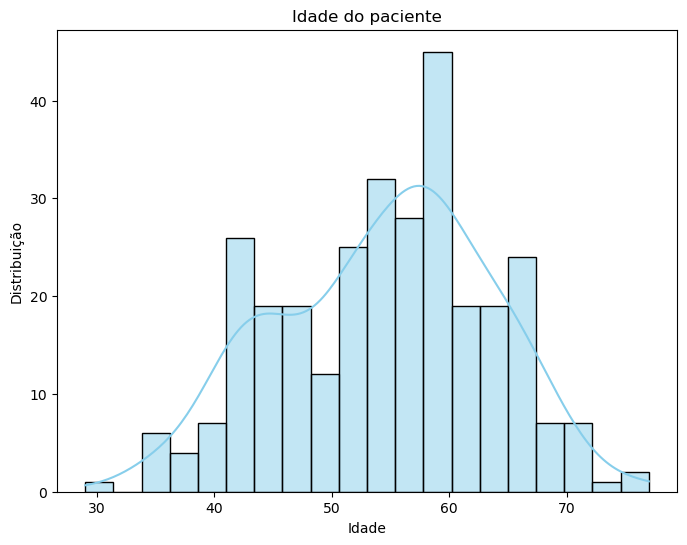

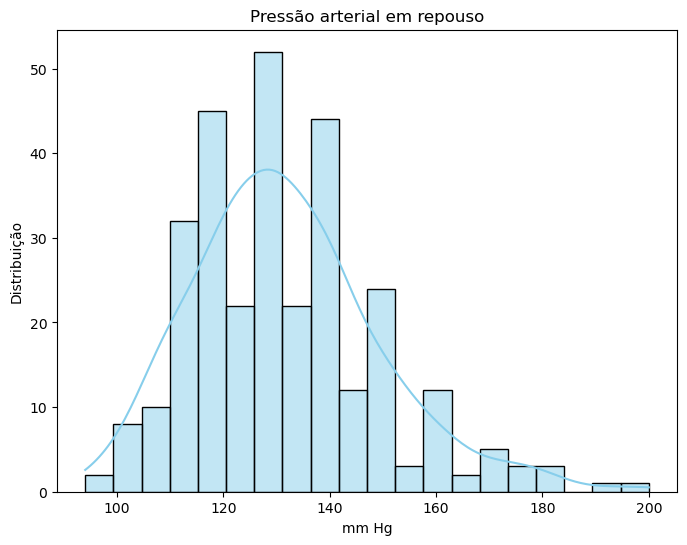

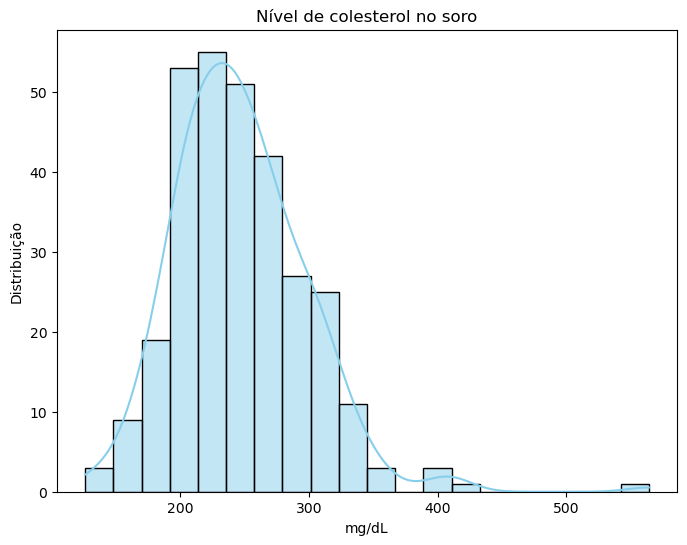

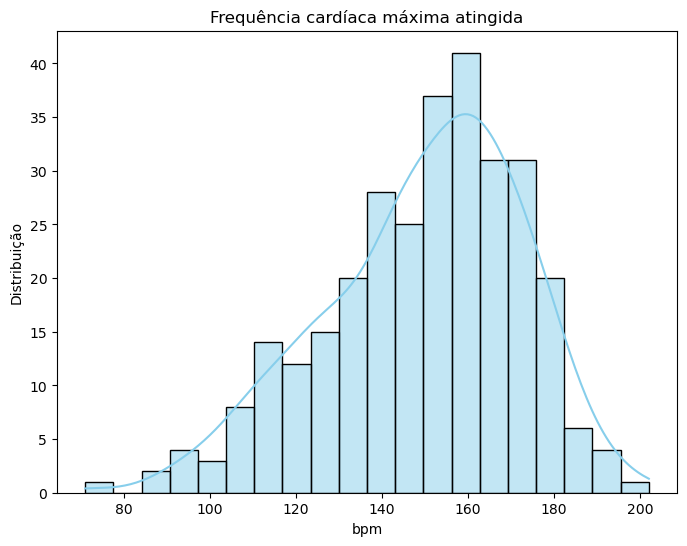

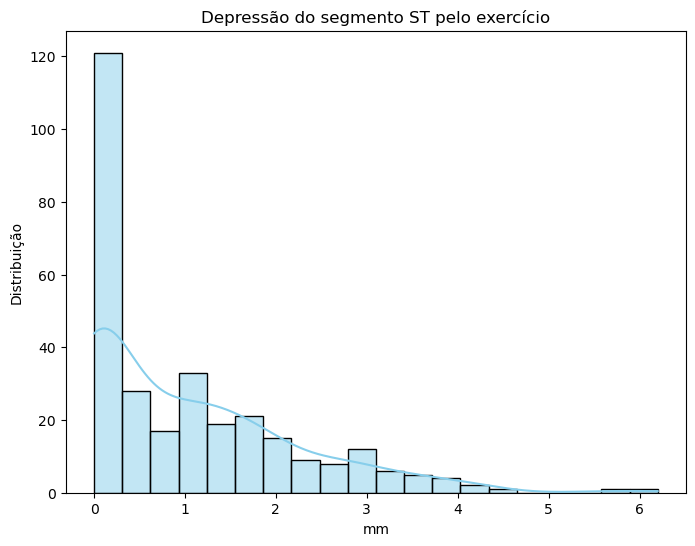

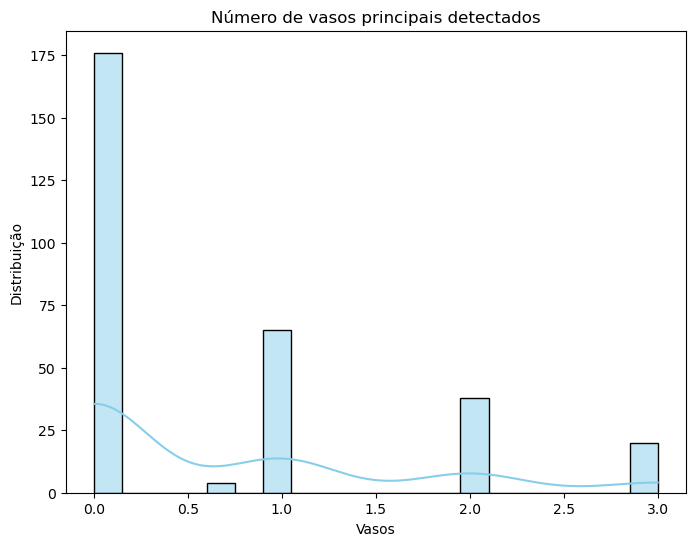

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

for index, row in Xnum_info.iterrows():
    
    plt.figure(figsize=(8, 6))
    sns.histplot(X[row["Var"]], kde=True, color='skyblue', bins=20)
    plt.title(row["Descrição"])
    if pd.isna(row["Unidade"]) or row["Unidade"] == "":
        plt.xlabel(row["Nome"])
    else:
        plt.xlabel(row["Unidade"])
    plt.ylabel('Distribuição')
    plt.show()

### Distribuição de Variáveis Qualitativas

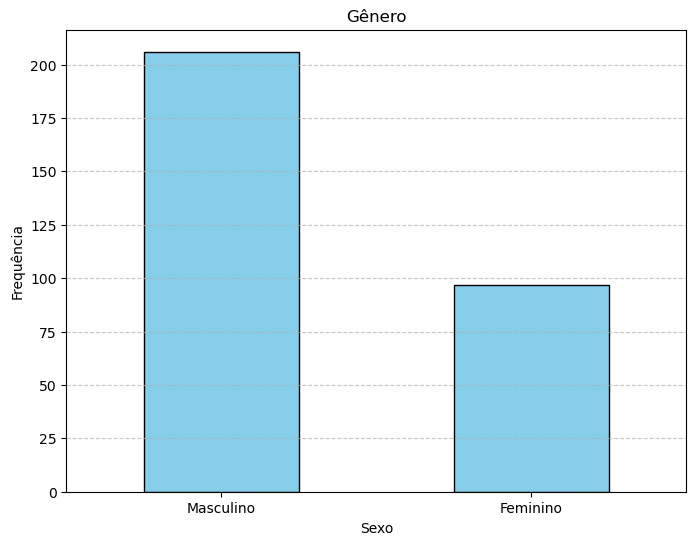

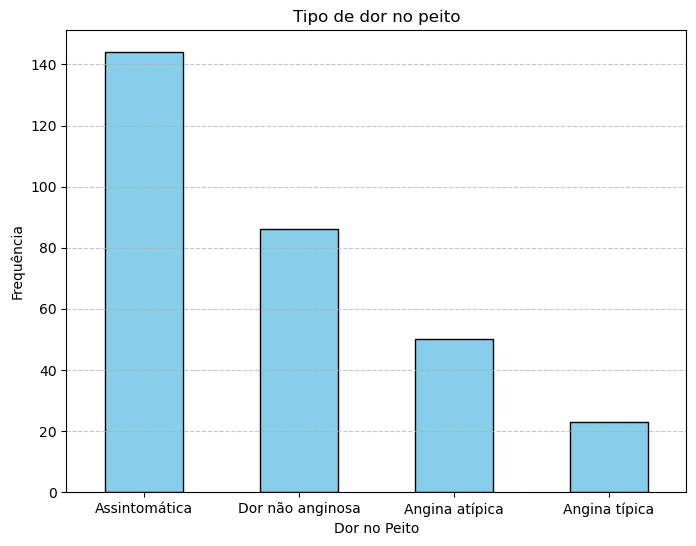

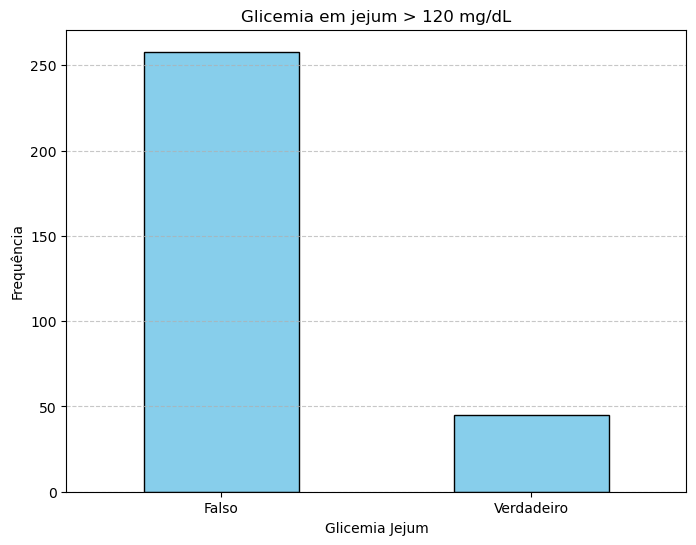

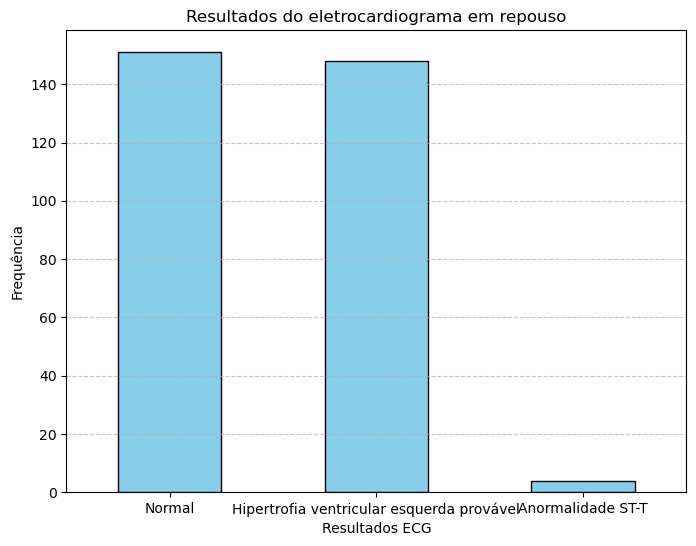

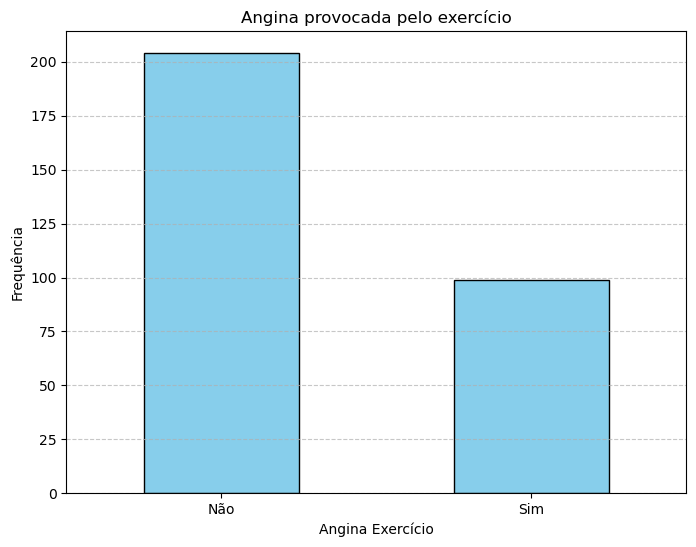

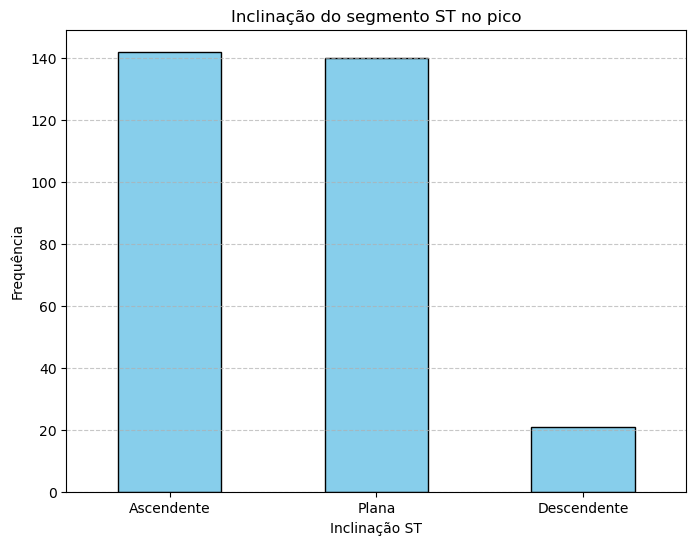

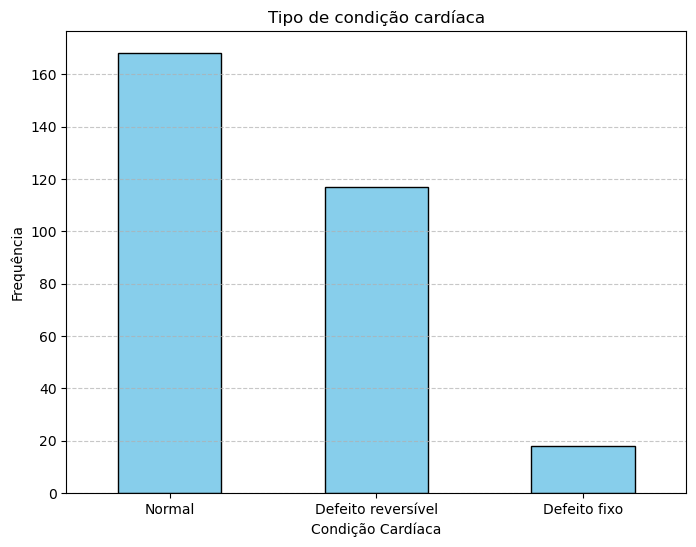

In [4]:
for index, row in Xcat_info.iterrows():
    # Variável Independente Categóricas
    plt.figure(figsize=(8, 6))
    
    counts = X[row["Var"]].map(row["Categorias"]).value_counts()
    
    # Barplot
    counts.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.title(row["Descrição"])
    plt.xlabel(row["Nome"])
    plt.ylabel("Frequência")
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

### Distribuição Da Variável Dependente

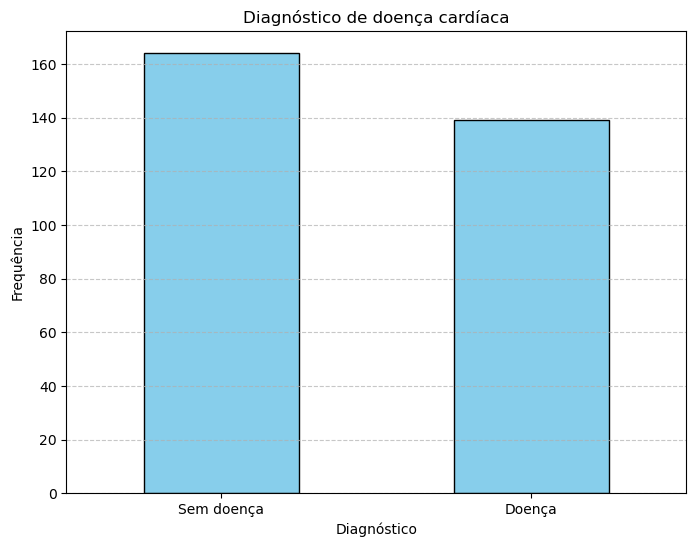

In [5]:
for index, row in y_info.iterrows():
    # Variável Dependente
    plt.figure(figsize=(8, 6))
    
    counts = y[row["Var"]].map(row["Categorias"]).value_counts()

    counts.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.title(row["Descrição"])
    plt.xlabel(row["Nome"])
    plt.ylabel("Frequência")
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

### Coeficiente de Contingência para Variáveis Qualitativas

Teste de coeficiente de contingência para variáveis qualitativas

A variável 'Sexo' tem uma FRACA Associação com o Diagnóstico (coef.: 0.270  <0.5).
A variável 'Dor no Peito' tem uma FORTE Associação com o Diagnóstico (coef.: 0.520  >0.5).
A variável 'Glicemia Jejum' tem uma FRACA Associação com o Diagnóstico (coef.: 0.016  <0.5).
A variável 'Resultados ECG' tem uma FRACA Associação com o Diagnóstico (coef.: 0.182  <0.5).
A variável 'Angina Exercício' tem uma FRACA Associação com o Diagnóstico (coef.: 0.425  <0.5).
A variável 'Inclinação ST' tem uma FRACA Associação com o Diagnóstico (coef.: 0.389  <0.5).
A variável 'Condição Cardíaca' tem uma FORTE Associação com o Diagnóstico (coef.: 0.522  >0.5).


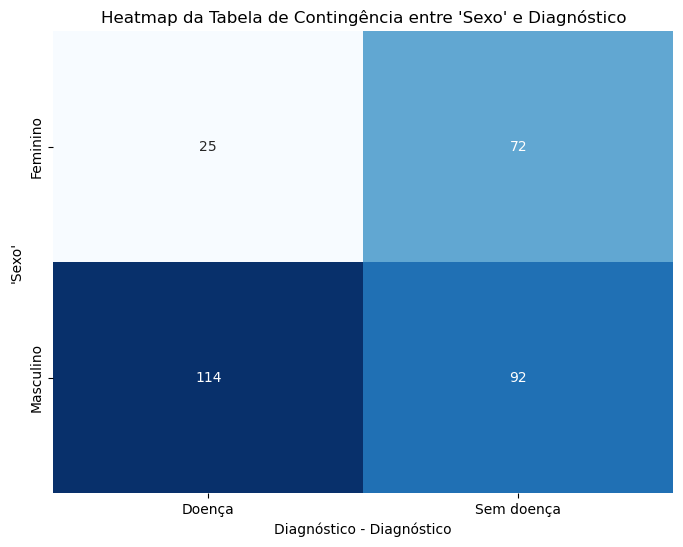

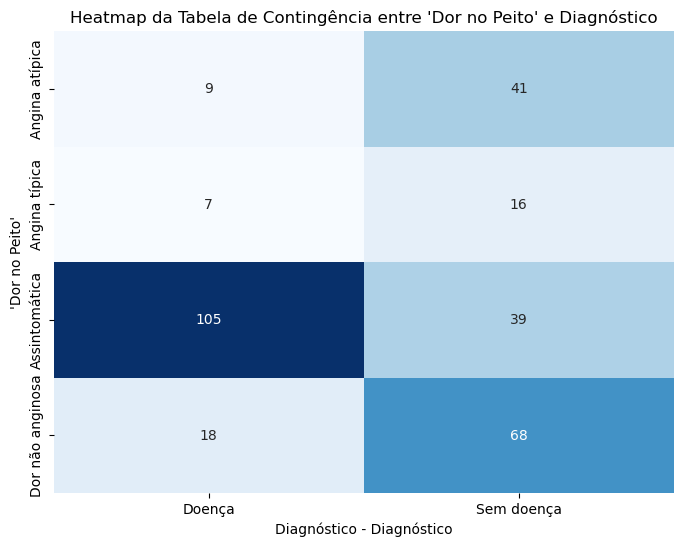

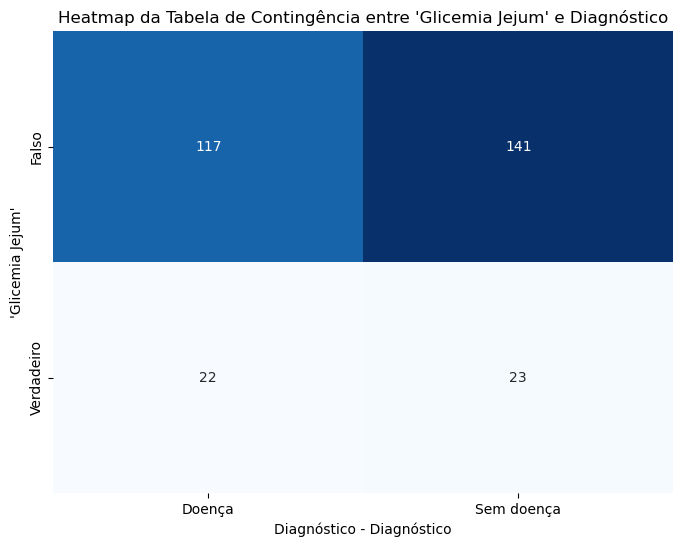

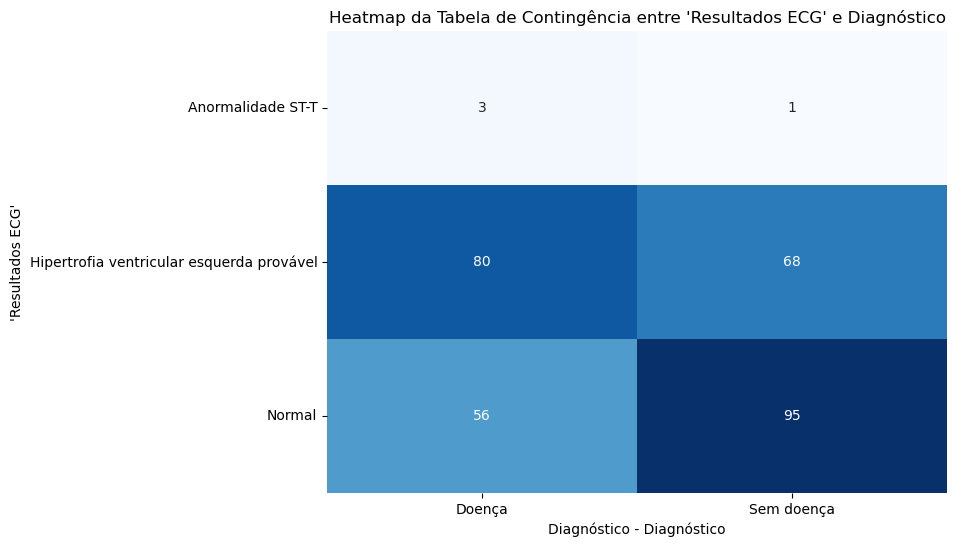

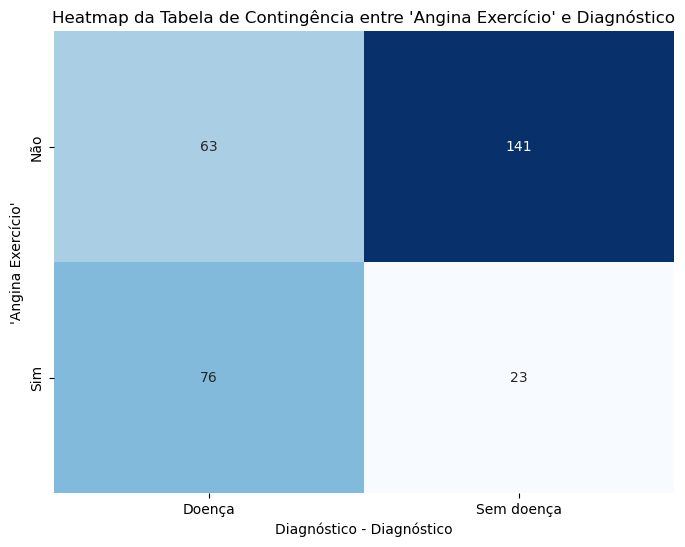

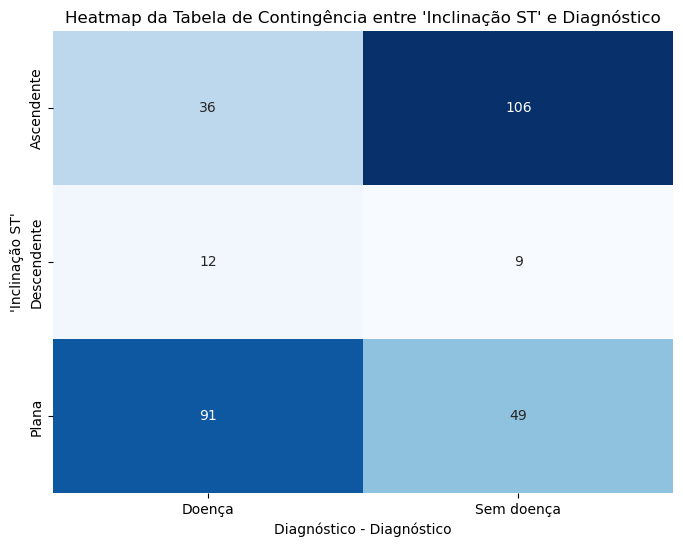

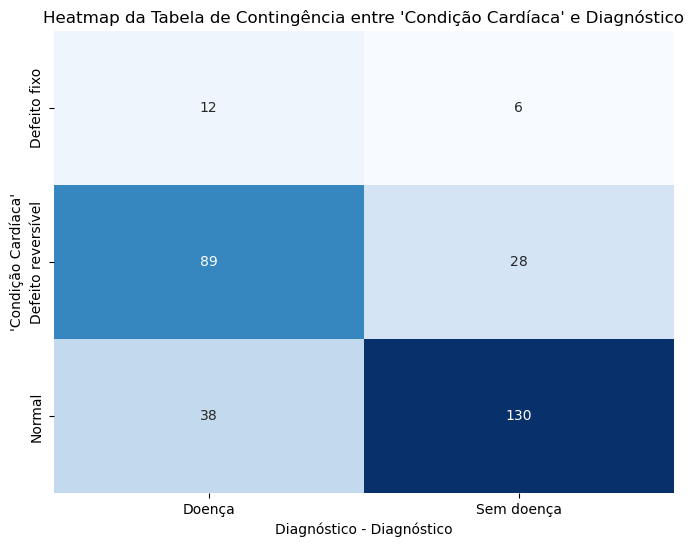

In [6]:
# slide 6
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

def coeficiente_contingencia(X_cat, y):
    cont_table = pd.crosstab(X_cat, y)
    
    # teste qui-quadrado
    chi2, p, dof, expected = chi2_contingency(cont_table)
    
    # coef.cont. Cramér
    n = cont_table.sum().sum()  # n total de observações
    min_dim = min(cont_table.shape) - 1  # menor valor entre o número de linhas e colunas
    c_contingencia = np.sqrt(chi2 / (n * min_dim))
    
    return c_contingencia

coef_contingencia_results = {}
for var in Xcat_info['Var']:
    X_var = X[var]
    # coef. cont entre X_var e y["num"]
    coef_contingencia = coeficiente_contingencia(X_var, y["num"])
    
    # resultado
    coef_contingencia_results[var] = coef_contingencia


print("Teste de coeficiente de contingência para variáveis qualitativas\n")
for index, row in Xcat_info.iterrows():
    coef_con = coef_contingencia_results[row['Var']]
    if coef_con == 0:
        msg=["uma ausência de Associação", "=0"]
    elif coef_con == 1:
        msg=["uma perfeita Associação", "=1"]
    elif coef_con < 0.5:
        msg=["uma FRACA Associação", "<0.5"]
    else:
        msg=["uma FORTE Associação", ">0.5"]
    
    print(f"A variável '{row['Nome']}' tem {msg[0]} com o Diagnóstico (coef.: {coef_con:.3f}  {msg[1]}).")

# mapeamento de categorias
def map_categorias(values, categorias_dict):
    return values.map(categorias_dict)

# Heatmap da Tabela de Contingência
for _, row in Xcat_info.iterrows():
    var = row['Var']
    X_var = X[var]
    
    # map dos valores numéricos para os nomes das categorias
    X_var_mapped = map_categorias(X_var, row['Categorias'])
    
    # map de y["num"] para os nomes das categorias
    y_mapped = map_categorias(y["num"], y_info.iloc[0]['Categorias'])
    
    # tabela de contingência
    cont_table = pd.crosstab(X_var_mapped, y_mapped)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cont_table, annot=True, cmap="Blues", fmt="d", cbar=False)
    plt.title(f"Heatmap da Tabela de Contingência entre '{row['Nome']}' e {y_info.iloc[0]['Nome']}")
    plt.xlabel(f"{y_info.iloc[0]['Nome']} - Diagnóstico")
    plt.ylabel(f"'{row['Nome']}'")
    plt.show()

### Análise ANOVA para variáveis Quantitativas

A variável 'Idade' tem uma diferença significativa entre o Diagnóstico (p-value: 0.000 < 0.05).


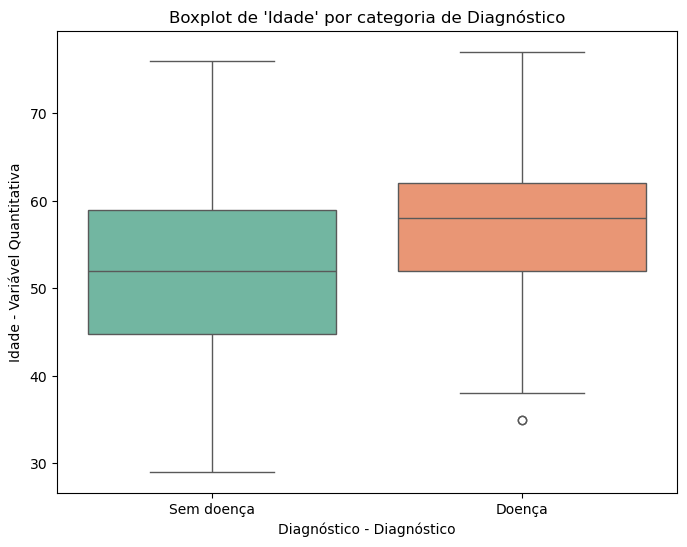

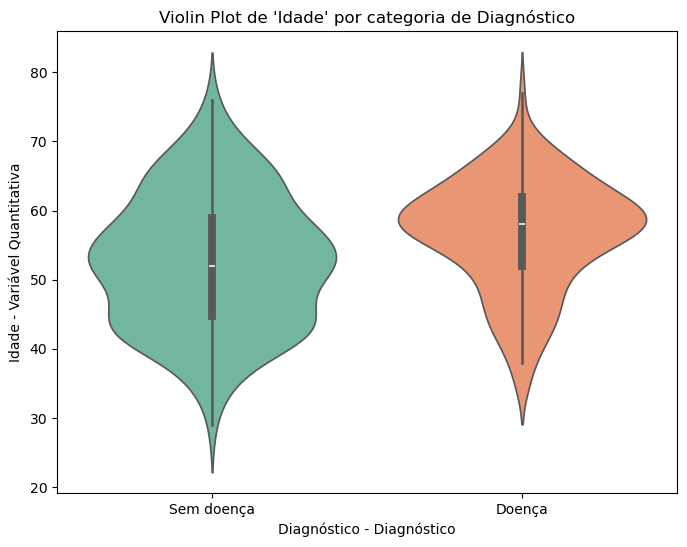

A variável 'PA em Repouso' tem uma diferença significativa entre o Diagnóstico (p-value: 0.009 < 0.05).


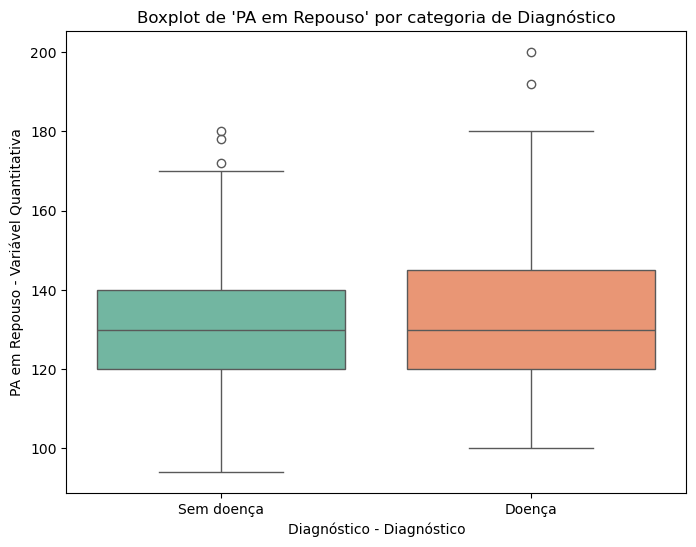

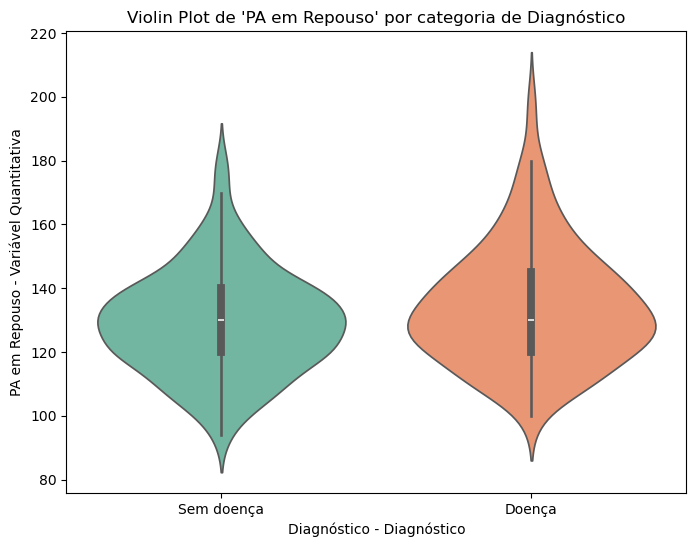

A variável 'Colesterol' NÃO tem uma diferença significativa entre o Diagnóstico (p-value: 0.139 > 0.05).


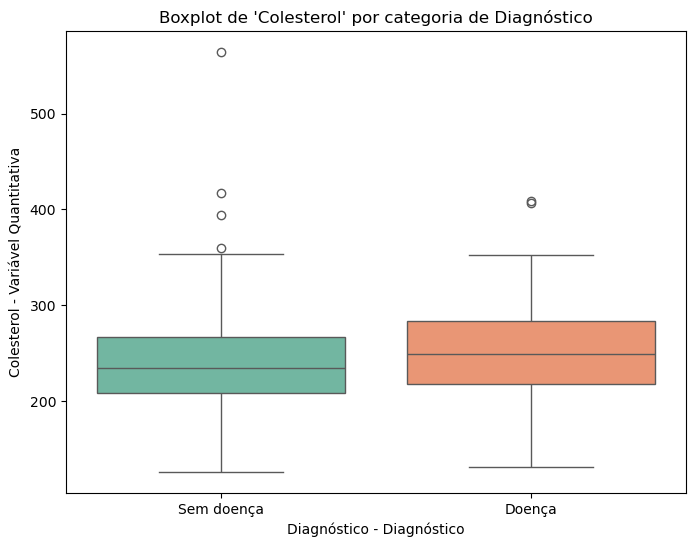

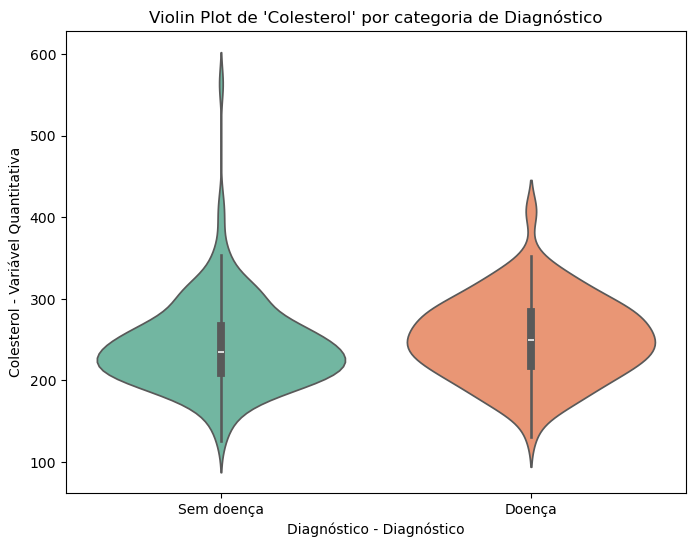

A variável 'FC Máxima' tem uma diferença significativa entre o Diagnóstico (p-value: 0.000 < 0.05).


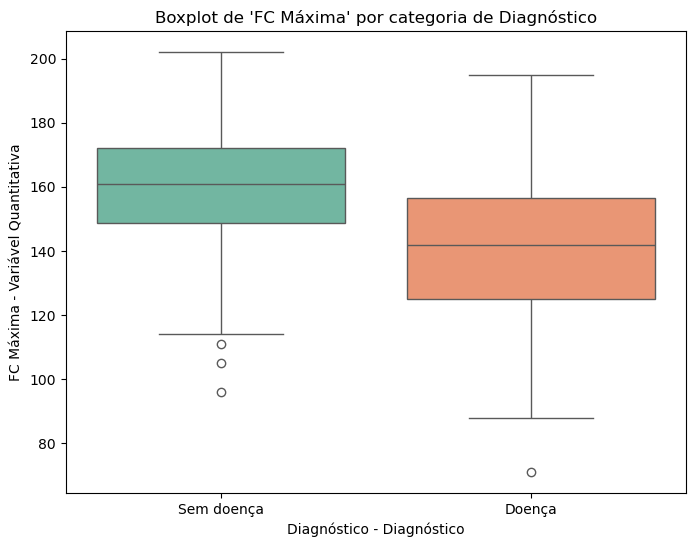

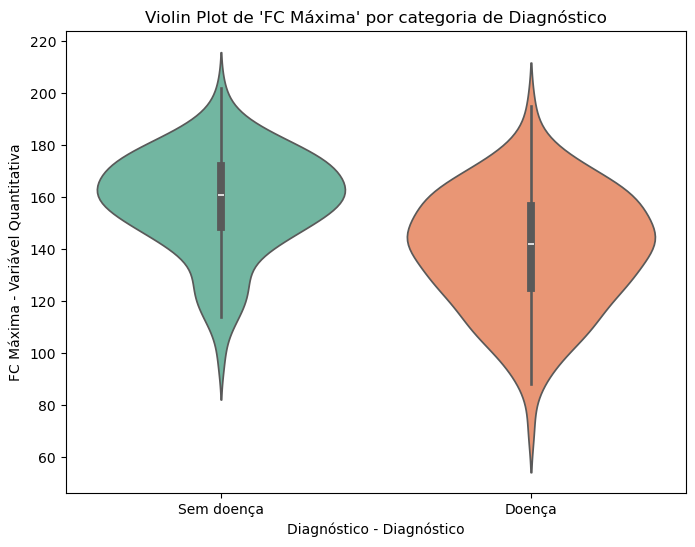

A variável 'Depressão ST' tem uma diferença significativa entre o Diagnóstico (p-value: 0.000 < 0.05).


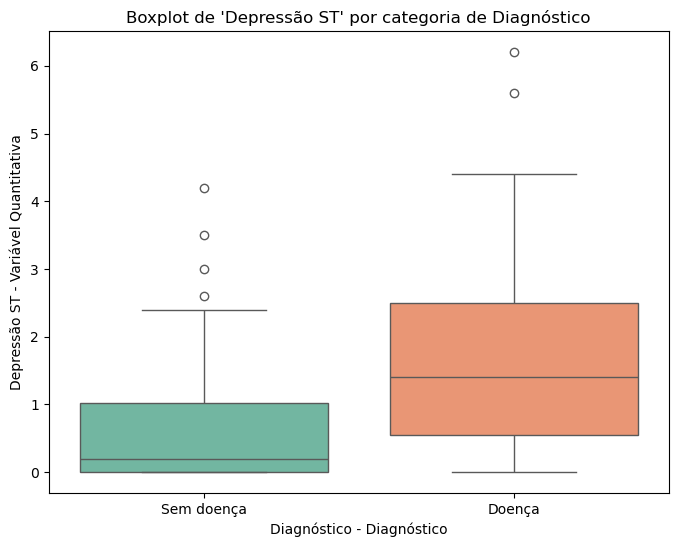

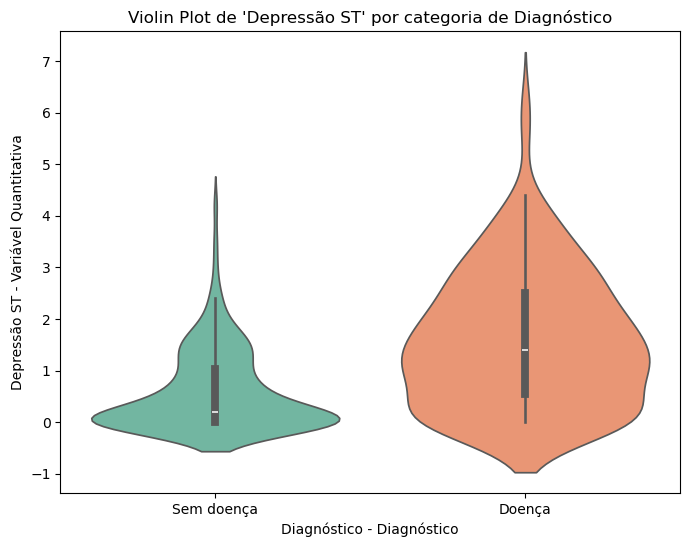

A variável 'Vasos' tem uma diferença significativa entre o Diagnóstico (p-value: 0.000 < 0.05).


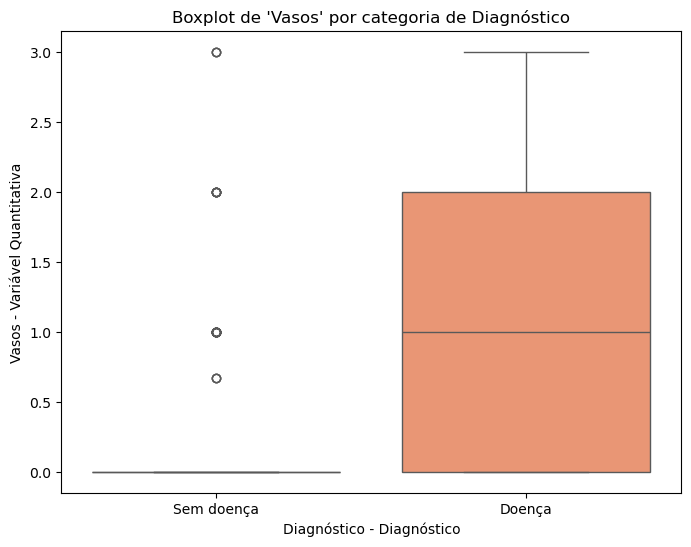

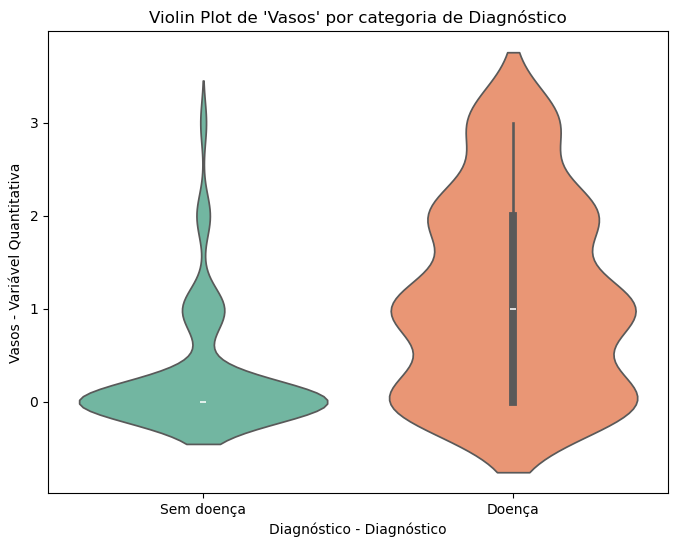

In [7]:
# slide 7
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

anova_results = {}

for var in Xnum_info['Var']: 
    X_var = X[var]
    
    # X_var pelas categorias de y["num"]
    groups = [X_var[y["num"] == category] for category in y["num"].unique()]
    
    # teste ANOVA
    f_stat, p_value = f_oneway(*groups)
    
    anova_results[var] = (f_stat, p_value)

# plots
for _, row in Xnum_info.iterrows():
    var = row['Var']
    X_var = X[var]
    
    # mapeio das categorias de y["num"]
    y_mapped = map_categorias(y["num"], y_info.iloc[0]['Categorias'])
    
    # dividir X_var pelas categorias de y["num"]
    groups = [X_var[y["num"] == category] for category in y_mapped.unique()]
    
    p_value = anova_results[row["Var"]][1]
    # exibir a mensagem sobre significância do p-value
    if p_value < 0.05:
        print(f"A variável '{row['Nome']}' tem uma diferença significativa entre o Diagnóstico (p-value: {p_value:.3f} < 0.05).")
    else:
        print(f"A variável '{row['Nome']}' NÃO tem uma diferença significativa entre o Diagnóstico (p-value: {p_value:.3f} > 0.05).")
    
    # Boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=y_mapped, y=X_var, hue=y_mapped, palette="Set2", legend=False)
    plt.title(f"Boxplot de '{row['Nome']}' por categoria de Diagnóstico")
    plt.xlabel(f"{y_info.iloc[0]['Nome']} - Diagnóstico")
    plt.ylabel(f"{row['Nome']} - Variável Quantitativa")
    plt.show()

    # Violin Plot
    plt.figure(figsize=(8, 6))
    sns.violinplot(x=y_mapped, y=X_var, hue=y_mapped, palette="Set2", legend=False)
    plt.title(f"Violin Plot de '{row['Nome']}' por categoria de Diagnóstico")
    plt.xlabel(f"{y_info.iloc[0]['Nome']} - Diagnóstico")
    plt.ylabel(f"{row['Nome']} - Variável Quantitativa")
    plt.show()

## Correlação entre Variáveis Independentes e Variável Dependente
A variáveis independentes qualitativas dos dados de origem apresentam suas classes em um sistema numérico de inteiros, possibilitando o cálculo da correlação de todas as variáveis com a variável dependente.

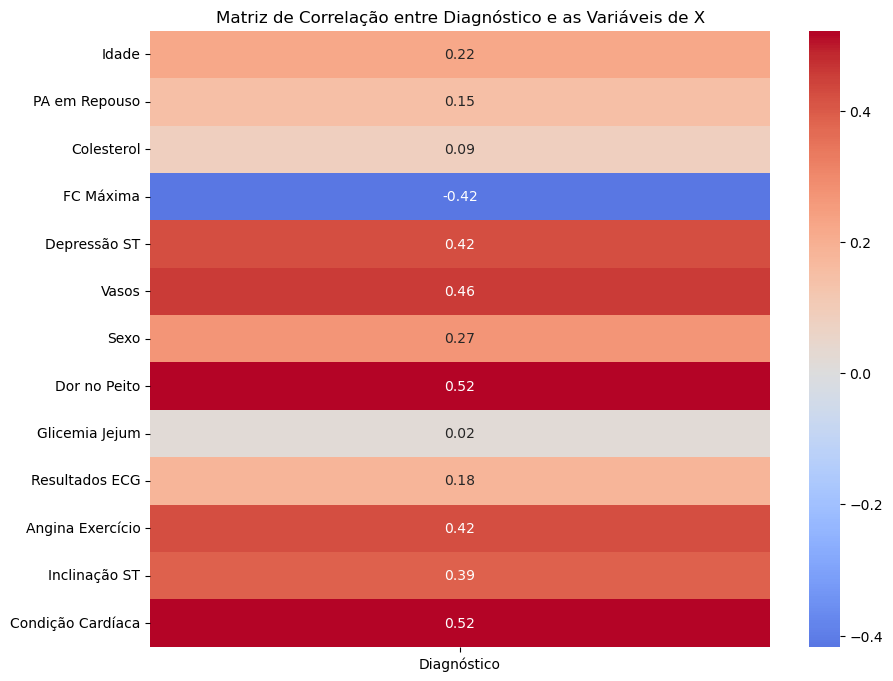

In [8]:
# slide 6 7
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# coef.cont Cramér novamente
def coeficiente_contingencia(X_cat, y):
    cont_table = pd.crosstab(X_cat, y)
    chi2, p, dof, expected = chi2_contingency(cont_table)
    n = cont_table.sum().sum()  # n total de observações
    min_dim = min(cont_table.shape) - 1  # menor valor entre o número de linhas e colunas
    c_contingencia = np.sqrt(chi2 / (n * min_dim))
    return c_contingencia

# correlações
correlation_results = {}

# correlação numéricas (Pearson)
for _, row in Xnum_info.iterrows():
    var = row['Var']
    X_var = X[var]
    
    # correlação de Pearson com y["num"]
    correlation = X_var.corr(y["num"])
    correlation_results[row["Nome"]] = correlation

# coef. cont. para variáveis categóricas
for _, row in Xcat_info.iterrows():
    var = row['Var']
    X_var = X[var]
    
    # coef. cont. com y["num"]
    c_contingencia = coeficiente_contingencia(X_var, y["num"])
    correlation_results[row["Nome"]] = c_contingencia

# matriz de correlação com os resultados
correlation_df = pd.DataFrame(correlation_results, index=[y_info.iloc[0]["Nome"]])

# Transpor a matriz (exibir em linhas)
correlation_df = correlation_df.T 

# Plotando o Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, center=0)
plt.title(f'Matriz de Correlação entre {y_info.iloc[0]["Nome"]} e as Variáveis de X')
plt.show()
